# Detection of fake accounts on Twitter.
## Motivation

In today's society, Social Networks are a primary source of information. Users utilize websites such as Twitter and Facebook to inform them selves about the latest events, discuss politics or social issues. It has also become a news outlet for traditional newspapers such as the New York Times or the Wall Street Journal. Politicians use Social Networks to communicate with the public. 

Independent parties use bots or large networks of bots which operate on these networks to fullfil their goals. Not all bots are malicious, such as bots which provide weather forecasts[1]. 

Three types of bot threads can be identified [1]. These bots often impersonate a real identity and therefore are difficult to distinguish from real users:
- Fraud: These types of bots deceive social media users to obtain money or private information.
- Promotion of harmful or censored information: Bots are utilized to spread propaganda or misinformation. These include:
    1. Thread to integrity: exacerbate conflict or violate the integrity of a community.
    2. Thread to availability: Drown alternative viewpoints with spam messages.

- Rating manipulation: Certain content is elevated through fake feedback including reviews, likes or followers.


With the increasing effectiveness as well as ease of access of generative AI, such as text and image generation models more sophisticated impersonations and generation of fake media can be achieved, difficult or impossible to distinguish from real content. Malicious-bot operators have gained access to multi-billion dollar means which camouflage their bots' behavior. The generative models, trained with human feedback to be indistinguishable from real content, diminish the out-of-distribution shift which was previously easily detectable. 

Thus the focus of this notebook shifts towards the behavioral and interaction patterns in social networks as well as user metadata to distinguish real from fake users.


[1] https://www.researchgate.net/profile/Maxim-Kolomeets/publication/358490063_Algorithms_and_techniques_for_bot_detection_in_social_networks/links/62afd5c5938bee3e3f438138/Algorithms-and-techniques-for-bot-detection-in-social-networks.pdf

## Dataset
Courtesy of Shangbin Feng this notebook uses the TwiBot-22 dataset[2] to analyze a social network graph of Twitter.
The authors try to ensure a distribution diversity (follower counts, user types) as well as value diversity (less similar neighbors are included) in the dataset. 

Human experts classify 1000 random users. Different classifiers are trained to distinguish the bots from the real users and their results are incorporated using the data augmentation technique Snorkel[3] to annotate the remaining users collected.

The dataset contains one million users as well as 88 million tweets. In total, the graph contains 92.9 million entities and 170 million relations amounting to a 6 GB file.



The graph comprises following node and edge types [2]:
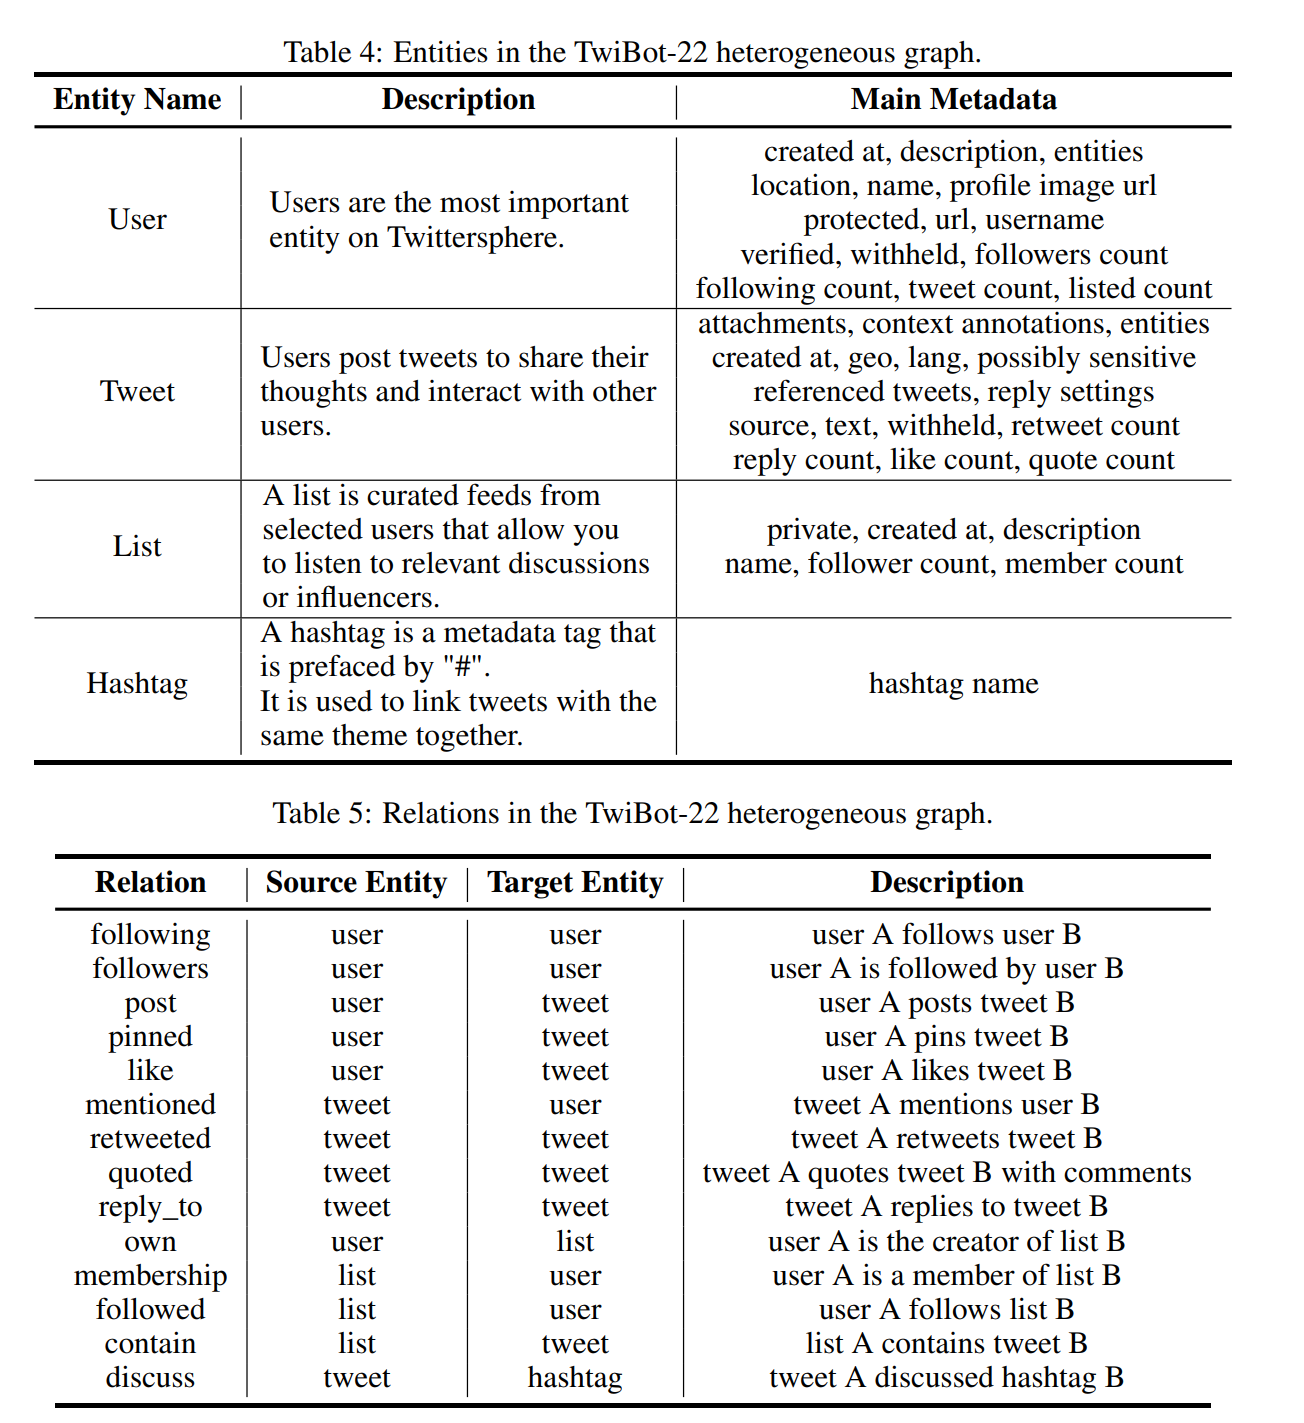

Besides the network information, TwiBot-22 also contains over 100 GB tweet information, which is not used in this notebook.

[2] https://arxiv.org/abs/2206.04564
[3] https://dawn.cs.stanford.edu/pubs/ratner-vldb2018.pdf

In [2]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [3]:
edges = pd.read_csv('data/edge.csv')
label = pd.read_csv('data/label.csv')


In [4]:
users = pd.read_json('data/user.json', lines=True)

In [5]:
a = users.values[0][1]
a

{'created_at': '2014-07-02 17:56:46+00:00',
 'description': 'creative _',
 'entities': None,
 'id': 'u2664730894',
 'location': '🎈',
 'name': 'olawale 💨',
 'pinned_tweet_id': None,
 'profile_image_url': 'https://pbs.twimg.com/profile_images/1478376381717401605/k4aboywe_normal.png',
 'protected': False,
 'public_metrics': {'followers_count': 123,
  'following_count': 1090,
  'tweet_count': 1823,
  'listed_count': 0},
 'url': '',
 'username': 'wale_io',
 'verified': False,
 'withheld': None}

In [6]:
# extract user data for training from jsons:

# {'created_at': '2014-07-02 17:56:46+00:00',
#  'description': 'creative _',
#  'entities': None,
#  'id': 'u2664730894',
#  'location': '🎈',
#  'name': 'olawale 💨',
#  'pinned_tweet_id': None,
#  'profile_image_url': 'https://pbs.twimg.com/profile_images/1478376381717401605/k4aboywe_normal.png',
#  'protected': False,
#  'public_metrics': {'followers_count': 123,
#   'following_count': 1090,
#   'tweet_count': 1823,
#   'listed_count': 0},
#  'url': '',
#  'username': 'wale_io',
#  'verified': False,
#  'withheld': None}
from tqdm.auto import tqdm

user_data = []
user_id = []
for row in tqdm(users.values.reshape(-1)):
    user_id.append(row['id'])
    user_data.append([row['public_metrics']['following_count'], row['public_metrics']['tweet_count'], row['public_metrics']['listed_count'], 0 if row['verified'] else 1, 0 if row['protected'] else 1])
    
user_data = np.array(user_data)

del users

c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000000/1000000 [00:02<00:00, 391112.74it/s]


In [7]:
import os
# make train and test split
if not os.path.exists('data/train.csv') or not os.path.exists('data/test.csv'):
    real_users = label[label.label=='human']
    bots = label[label.label=='bot']

    # random idx
    idx1 = np.random.permutation(len(real_users))
    idx2 = np.random.permutation(len(bots))
    real_users = real_users.iloc[idx1]
    bots = bots.iloc[idx2]

    real_train_users = real_users.iloc[:int(len(real_users)*0.90)]
    real_test_users = real_users.iloc[int(len(real_users)*0.90):]

    bot_train_users = bots.iloc[:int(len(bots)*0.90)]
    bot_test_users = bots.iloc[int(len(bots)*0.90):]

    data = []
    for i in real_train_users.values:
        data.append([i[0], 0])

    for i in bot_train_users.values:
        data.append([i[0], 1])
        
    train_df = pd.DataFrame(data, columns=['user_id', 'label'])

    data = []
    for i in real_test_users.values:
        data.append([i[0], 0])

    for i in bot_test_users.values:
        data.append([i[0], 1])

    test_df = pd.DataFrame(data, columns=['user_id', 'label'])
    train_df.to_csv('data/train.csv', index=False)
    test_df.to_csv('data/test.csv', index=False)
else:
    train_df = pd.read_csv('data/train.csv')
    test_df = pd.read_csv('data/test.csv')
    
print(train_df.shape, test_df.shape)

(899999, 2) (100001, 2)


In [8]:
# real people: 0, bots: 1
train_df.value_counts('label'), test_df.value_counts('label')

(label
 0    774051
 1    125948
 Name: count, dtype: int64,
 label
 0    86006
 1    13995
 Name: count, dtype: int64)

In [9]:
# extract relationship counts for each user
edges['relation'].value_counts()

relation
post          88217457
discuss       66000633
mentioned      4759388
following      2626979
contain        1998788
retweeted      1580643
followers      1116655
replied_to     1114980
membership     1022587
like            595794
followed        493556
pinned          347131
quoted          289476
own              21870
Name: count, dtype: int64

In [10]:
# extract relationship counts for each user
user_relationship_counts = pd.pivot_table(edges, index='source_id', columns='relation', aggfunc='size', fill_value=0)
user_relationship_counts.reset_index(inplace=True)

user_relationship_users_only_counts = user_relationship_counts[user_relationship_counts.source_id.isin(user_id)]

In [11]:
user_relationship_users_only_counts.shape
accounts_without_interactions = len(user_id) - len(user_relationship_users_only_counts)

# add all users without interactions to the dataframe with 0 in each column
data = []
for user_without_interactions in set(user_id) - set(user_relationship_users_only_counts.source_id.values):
    data.append([user_without_interactions] + [0]*len(user_relationship_users_only_counts.columns[1:]))

# concat the two dataframes
user_relationship_users_only_counts = pd.concat([user_relationship_users_only_counts, pd.DataFrame(data, columns=user_relationship_users_only_counts.columns)])

In [12]:
user_relationship_users_only_counts.shape

(1000000, 15)

In [13]:
# make user_data df for faster indexing 
user_data_df = pd.DataFrame(user_data, columns=['following_count', 'tweet_count', 'listed_count', 'verified', 'protected'])
user_data_df['user_id'] = user_id
user_data_df['verified'] = 1 - user_data_df['verified'] 

In [14]:
# sort train_X by user_id

In [20]:
from functools import partial

# train simple logistic regression
train_X1 = user_relationship_users_only_counts.loc[user_relationship_users_only_counts.source_id.isin(train_df.user_id.values)]  # .drop('source_id', axis=1).values   
train_X2 = user_data_df[user_data_df.user_id.isin(train_df.user_id.values)]  # .drop('user_id', axis=1)

train_X1.index = train_X1.source_id.values
train_X1 = train_X1.loc[train_df.user_id.values]
train_X1.drop('source_id', axis=1, inplace=True)

train_X2.index = train_X2.user_id.values
train_X2 = train_X2.loc[train_df.user_id.values]
train_X2.drop('user_id', axis=1, inplace=True)

train_X = np.concatenate([train_X1.values, train_X2.values], axis=1)

train_y = train_df.label.values

shuffled = np.random.permutation(len(train_X))
train_X = train_X[shuffled]
train_y = train_y[shuffled]

val_X = train_X[-int(len(train_X)*0.1):]
val_y = train_y[-int(len(train_y)*0.1):]

train_X = train_X[:-int(len(train_X)*0.1)]
train_y = train_y[:-int(len(train_y)*0.1)]

# # scale train_X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fitted_scaler = scaler.fit(train_X)
train_X = fitted_scaler.transform(train_X)
val_X = fitted_scaler.transform(val_X)

# test data
test_X1 = user_relationship_users_only_counts.loc[user_relationship_users_only_counts.source_id.isin(test_df.user_id.values)]  # .drop('source_id', axis=1).values
test_X2 = user_data_df[user_data_df.user_id.isin(test_df.user_id.values)]  # .drop('user_id', axis=1)
test_X1.index = test_X1.source_id.values
test_X1 = test_X1.loc[test_df.user_id.values]
test_X1.drop('source_id', axis=1, inplace=True)

test_X2.index = test_X2.user_id.values
test_X2 = test_X2.loc[test_df.user_id.values]
test_X2.drop('user_id', axis=1, inplace=True)

test_X = np.concatenate([test_X1.values, test_X2.values], axis=1)
test_y = test_df.label.values



# train_X.shape, train_y.shape
train_X.shape, train_y.shape, val_X.shape, val_y.shape

test user id ['u1232058194593271808' 'u994691295040884736' 'u1075376835314311173' ...
 'u1196334959549661184' 'u2150285052' 'u1489977773192093696']
test user id ['u1232058194593271808' 'u994691295040884736' 'u1075376835314311173' ...
 'u1196334959549661184' 'u2150285052' 'u1489977773192093696']


((810000, 19), (810000,), (89999, 19), (89999,))

100%|██████████| 150/150 [00:07<00:00, 21.42it/s]


epoch: 149 loss: 0.9221243262290955 f
train f1: 0.41658536129926754 precision: 0.28321521855729653 recall: 0.7873686439556368
val f1: 0.42180623973727416 precision: 0.2913440600048391 recall: 0.7638569502815002
best lr: 0.01 val f1: 0.42180623973727416


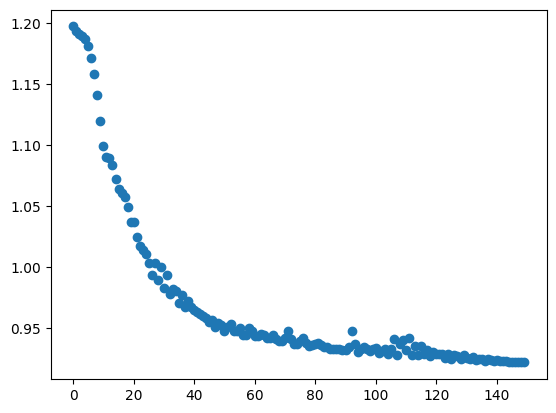

In [19]:
import torch
class Classifier(torch.nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.linear = torch.nn.Linear(input_size, input_size)
        self.linear1 = torch.nn.Linear(input_size, input_size)
        self.linear2 = torch.nn.Linear(input_size, input_size)
        self.linear3 = torch.nn.Linear(input_size, input_size)
        self.linear4 = torch.nn.Linear(input_size, input_size)
        self.linear5 = torch.nn.Linear(input_size, input_size)
        self.linear6 = torch.nn.Linear(input_size, 1)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        y_pred = F.sigmoid(self.linear6(x))
        return y_pred


def make_model(lr):
    model = Classifier(train_X.shape[1])
    X = torch.from_numpy(train_X).float()
    y = torch.from_numpy(train_y).float().unsqueeze(1)

    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.functional.binary_cross_entropy
    rescale_weight_botsamples = len(train_y[train_y==0])/len(train_y[train_y==1])

    model.train()
    model.cuda()
    X = X.cuda()
    y = y.cuda()
    
    for epoch in tqdm(range(150)):
        y_pred = model(X)
        weights = torch.ones_like(y).cuda()
        weights[y==1] = rescale_weight_botsamples
        loss = criterion(y_pred, y, weight = weights)
        
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(y.detach().cpu(), y_pred.detach().cpu()>0.5)
    precision = precision_score(y.detach().cpu(), y_pred.detach().cpu()>0.5)

    recall = recall_score(y.detach().cpu(), y_pred.detach().cpu()>0.5)
    print(f'epoch: {epoch} loss: {loss.item()} f')
    print(f'train f1: {f1} precision: {precision} recall: {recall}')
    
    # validation set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.from_numpy(val_X).float().cuda())
        f1 = f1_score(val_y, y_pred.detach().cpu()>0.5)
        precision = precision_score(val_y, y_pred.detach().cpu()>0.5)
        recall = recall_score(val_y, y_pred.detach().cpu()>0.5)
        print(f'val f1: {f1} precision: {precision} recall: {recall}')
    
    return f1, losses, model
        
# line search
if False:
    lrs = [0.0001, 0.001, 0.01, 0.1,0.2]
    lrs = [str(lr) for lr in lrs]
    best_lr = None
    best_f1 = 0
    best_model = None
    best_losses = None
    for lr in lrs:
        print(f'lr: {lr}')
        f1, losses, model = make_model(float(lr))
        if f1 > best_f1:
            best_f1 = f1
            best_lr = lr
            best_model = model
            best_losses = losses
f1, losses, model = make_model(0.01)
print(f'best lr: {0.01} val f1: {f1}')
plt.scatter(range(len(losses)), losses)
plt.show()


In [ ]:
y.shape

torch.Size([810000, 1])

In [ ]:
y_pred

tensor([[0.4004],
        [0.3609],
        [0.3914],
        ...,
        [0.3901],
        [0.3765],
        [0.3851]], grad_fn=<SigmoidBackward0>)

In [ ]:
# train simple logistic regression
model = LogisticRegression()
model.fit(train_X, train_y)

LogisticRegression()

In [ ]:
# get f1 score
def get_f1(y_hat, y):
    tp = ((y_hat==1) & (y==1)).sum()
    #tn = ((y_hat==0) & (y==0)).sum()
    fp = ((y_hat==1) & (y==0)).sum()
    fn = ((y_hat==0) & (y==1)).sum()
    
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn) 
    print(precision, recall)
    f1 = 2*precision*recall/(precision+recall)
    return f1

y_hat = model.predict(train_X)

# accuracy
print('Train f1:', get_f1(y_hat, train_y))

test_X1 = user_relationship_users_only_counts.loc[user_relationship_users_only_counts.source_id.isin(test_df.user_id.values)].drop('source_id', axis=1).values
test_X2 = user_data_df[user_data_df.user_id.isin(test_df.user_id.values)].drop('user_id', axis=1).values
test_X = np.concatenate([test_X1, test_X2], axis=1)
test_X = fitted_scaler.transform(test_X)
test_y = test_df.label.values
y_hat = model.predict(test_X)

print('Test f1:', get_f1(y_hat, test_y))


0.3575418994413408 0.0005648969504391191
Train f1: 0.00112801170312142
0.125 7.145409074669524e-05
Test f1: 0.0001428265371706063
